In [127]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import seaborn as sns
sns.set(style="darkgrid")
from scipy import stats
import matplotlib.patches as mpatches

In [128]:
data_types = {'Recall Notification Date': str}
df = pd.read_csv("database.csv", dtype=data_types)

In [129]:
df.dtypes

Record ID                     int64
NHTSA Campaign               object
Manufacturer Campaign        object
Vehicle Make                 object
Vehicle Model                object
Model Year                    int64
Vehicle Manufacturer         object
Recall Type                  object
Recall Component             object
Manufacture Start Date      float64
Manufacture End Date        float64
Estimated Units             float64
Recall Initiative            object
Recall Manufacturer          object
Recall Notification Date     object
dtype: object

In [130]:
ford_aliases = {
    'TOYOTA MOTOR CO., LTD.',
    'TOYOTA MOTOR NORTH AMERICA, INC.',
    'Toyota Motor Engineering & Manufacturing'
}

In [131]:
ford_df = df.loc[df['Vehicle Manufacturer'].isin(ford_aliases)]

In [132]:
ford_df_over_1_mil = ford_df.loc[df['Estimated Units'] > 1000000.0]

In [133]:
len(ford_df_over_1_mil)

309

In [134]:
ford_df_filtered = ford_df_over_1_mil.dropna(subset=['Recall Notification Date'])

In [135]:
ford_series_filtered_with_date = ford_df_filtered['Recall Notification Date'].apply(lambda x:pd.datetime.strptime(x, '%Y%m%d'))

In [136]:
type(ford_df_filtered['Estimated Units'])

pandas.core.series.Series

In [137]:
date_split_value = pd.datetime(1995, 1, 1) # ignore values before 1995

In [138]:
recalls_by_units_df = pd.DataFrame({
        'Recall Notification Date': ford_series_filtered_with_date,
        'Estimated Units': ford_df_filtered['Estimated Units']
})

In [139]:
recalls_by_units_df_after_1995 = recalls_by_units_df.loc[recalls_by_units_df['Recall Notification Date'] > date_split_value]

In [140]:
recalls_by_unit_after_1995_unique = recalls_by_units_df_after_1995.drop_duplicates()

In [158]:
ford_stock_data_types = {
    'Date': str,
    'Price': float
}
ford_stock = pd.read_csv('zstock_data_clean/toyota_stock.txt', sep='\t', parse_dates=['Date'])

In [159]:
ford_stock_after_1995 = ford_stock.loc[ford_stock['Date'] > date_split_value]

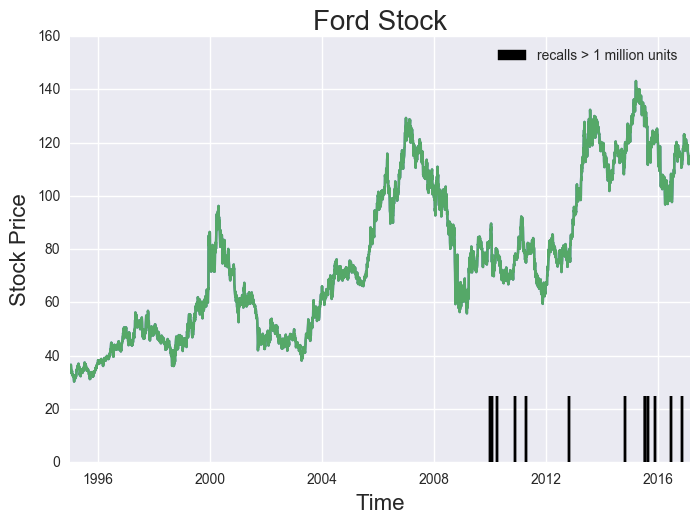

In [163]:
plt.plot(list(ford_stock_after_1995['Date']), list(ford_stock_after_1995['Price']))
#plt.scatter(list(recalls_by_unit_after_1995_unique['Recall Notification Date']), [25 for x in range(0, len(recalls_by_unit_after_1995_unique))])
#for i in range(0, len(recalls_by_unit_after_1995_unique))
#    plt.plot([, ])
my_dates_list = list(recalls_by_unit_after_1995_unique['Recall Notification Date'])
plt.vlines(x=my_dates_list, ymin=[0 for x in range(0, len(my_dates_list))], ymax=[25 for x in range(0, len(my_dates_list))])
plt.title('Ford Stock', fontsize=20)
plt.xlabel('Time', fontsize=16)
plt.ylabel('Stock Price', fontsize=16)
black_patch = mpatches.Patch(color='black', label='recalls > 1 million units')
plt.legend(handles=[black_patch],
           loc='upper right')
plt.show()

In [164]:
type(ford_stock_after_1995['Date'][5707])

pandas.tslib.Timestamp

In [165]:
SnP_data_frame = pd.read_csv("MarketIndexData/YAHOO-INDEX_GSPC.csv")
SnP_data_frame.drop(['Open', 'High', 'Low', 'Volume', 'Adjusted Close'], axis=1, inplace=True)

In [166]:
SnP_data_frame['RealDate'] = SnP_data_frame['Date'].apply(lambda x:pd.datetime.strptime(x, '%Y-%m-%d'))
type(SnP_data_frame['RealDate'][0])

pandas.tslib.Timestamp

In [167]:
SnP_data_frame_after_1995 = SnP_data_frame.loc[SnP_data_frame['RealDate'] > date_split_value]

In [168]:
#SnP_data_frame_after_1995

In [169]:
#SnP_data_frame_after_1995

In [170]:
SnP_data_frame.dtypes

Date                object
Close              float64
RealDate    datetime64[ns]
dtype: object

In [171]:
ford_stock_after_1995_reset_indices = ford_stock_after_1995.reset_index()
ford_stock_after_1995_reset_indices.drop('index', axis=1, inplace=True)

In [172]:
# now we have the company stock and the index stock
# we will join them on date
company_market_index_join_df = pd.merge(SnP_data_frame_after_1995, ford_stock_after_1995_reset_indices, left_on='RealDate', right_on='Date', how='inner')
company_market_index_join_df.head()

,Date_x,Close,RealDate,Date_y,Price
0,2017-02-24,2367.340088,2017-02-24,2017-02-24,113.769997
1,2017-02-23,2363.810059,2017-02-23,2017-02-23,114.589996
2,2017-02-22,2362.820068,2017-02-22,2017-02-22,114.400002
3,2017-02-21,2365.379883,2017-02-21,2017-02-21,114.300003
4,2017-02-17,2351.159912,2017-02-17,2017-02-17,113.699997


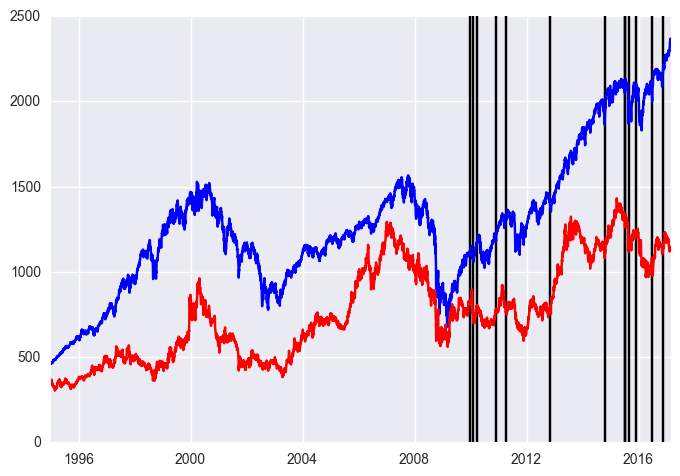

In [185]:
plt.plot(company_market_index_join_df['Date_y'], company_market_index_join_df['Close'], c='blue')
plt.plot(company_market_index_join_df['Date_y'], np.array(company_market_index_join_df['Price'])*10, c='red')
plt.vlines(x=my_dates_list, ymin=[0 for x in range(0, len(my_dates_list))], ymax=[2500 for x in range(0, len(my_dates_list))])
plt.show()

In [186]:
print(type(company_market_index_join_df['Date_y'][0]))

<class 'pandas.tslib.Timestamp'>


In [187]:
# now we will conduct the event study
company_stock_dates_arr = np.array(ford_stock_after_1995_reset_indices['Date'])
company_stock_prices_arr = np.array(ford_stock_after_1995_reset_indices['Price'])
recalls_dates_arr = np.array(recalls_by_unit_after_1995_unique['Recall Notification Date'])

In [188]:
#recalls_dates_arr

In [201]:
estimation_window = 20
event_window = 20

In [202]:
# we'll get the event window's company prices and market index closes so we can calculate the abnormal returns
indexes_of_event_dates_in_df = set()
for event_date in recalls_dates_arr:
    idx = np.argwhere(company_market_index_join_df['Date_y'] == event_date)
    while(len(idx) != 1):
        event_date -= np.timedelta64(1,'D')
        idx = np.argwhere(company_market_index_join_df['Date_y'] == event_date)
    assert(len(idx) == 1)
    indexes_of_event_dates_in_df.add(idx[0][0])
#indexes_of_event_dates_in_df
# now I must pull out prices and market index values in the event window for each event.
event_window_company_prices = []
event_window_market_index_values = []

for index in indexes_of_event_dates_in_df:
    upper_limit_index = index + event_window + 1
    company_stock_prices_array = company_market_index_join_df['Price'][index:upper_limit_index]
    market_index_values_array = company_market_index_join_df['Close'][index:upper_limit_index]
    event_window_company_prices.append(np.array(company_stock_prices_array))
    event_window_market_index_values.append(np.array(market_index_values_array))

In [203]:
import event_study.market_return_model as mrm

In [204]:
company_prices_returns = [np.array(mrm.calculate_returns(ret)) for ret in event_window_company_prices]
market_index_returns = [np.array(mrm.calculate_returns(ret)) for ret in event_window_market_index_values]

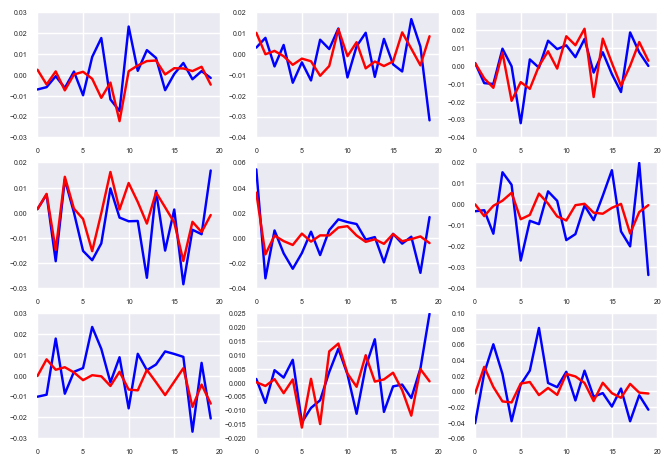

In [205]:
num_cols = 3
num_rows = 3
f, axarr = plt.subplots(num_rows, num_cols)
ith_period = 0

for col in range(0, num_cols):
    for row in range(0, num_rows):
        axarr[row, col].tick_params(labelsize=5)
        if ith_period >= len(company_prices_returns):
            continue
        axarr[row, col].plot(company_prices_returns[ith_period], c='blue')
        axarr[row, col].plot(market_index_returns[ith_period], 'red')
        ith_period += 1
plt.show()

In [206]:
abnormal_returns = mrm.calculate_abnormal_returns(list_of_stock_price_arrays=company_prices_returns,
                                                  list_of_market_index_arrays=market_index_returns)
car = mrm.calculate_cumulative_abnormal_returns(abnormal_returns=abnormal_returns)
caar = mrm.calculate_cumulative_average_abnormal_returns(car)

n = len(car)
stdev = np.sqrt(np.sum(np.square(car-caar)) / n)
t_statistic = np.sqrt(n) * (caar / stdev)
print("t_statistic:", t_statistic)
print("DoF:", n-1)
print("stdev:", stdev)

t_statistic: -0.110184620842
DoF: 11
stdev: 0.0505693188223


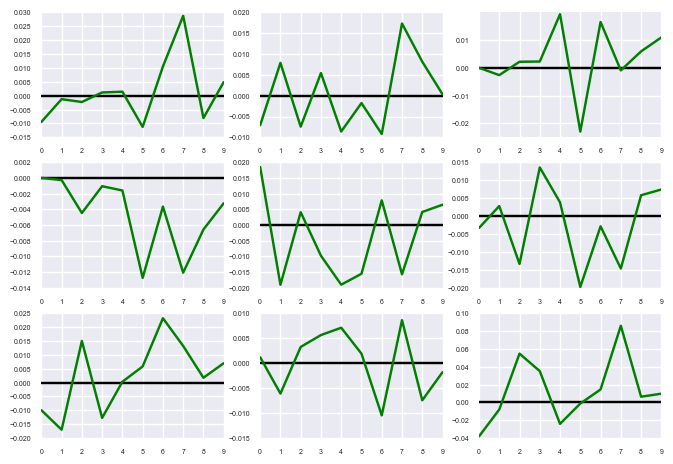

In [224]:
num_cols = 3
num_rows = 3
f, axarr = plt.subplots(num_rows, num_cols)
ith_period = 0

for col in range(0, num_cols):
    for row in range(0, num_rows):
        axarr[row, col].tick_params(labelsize=5)
        if ith_period >= len(abnormal_returns):
            continue
        axarr[row, col].plot(abnormal_returns[ith_period], c='green')
        axarr[row, col].hlines(y=0, xmin=0, xmax=len(abnormal_returns[ith_period])-1)
        ith_period += 1
plt.show()

In [86]:
caar

0.031278487998993888